# KAGGLE - Binary Classification code

## 1. import library

In [1]:
import pandas as pd
import numpy as np
import optuna
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score,confusion_matrix, silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer

from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())

/Users/yj.noh/Documents/GitHub


## 2. dataset load

In [2]:
train = pd.read_csv("/Users/yj.noh/Documents/GitHub/kaggle-Binary/train.csv", encoding = "utf-8")
test = pd.read_csv("/Users/yj.noh/Documents/GitHub/kaggle-Binary/test.csv", encoding = "utf-8")

print(train.shape) #101,763, 23
print(test.shape) # 67,842

(101763, 23)
(67842, 22)


## 3. Data EDA

In [3]:
# NA check 
print(train.isna().sum())
print(test.isna().sum())

id                   0
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64
id                   0
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             

In [4]:
train.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [6]:
# category화 할수 있는 변수 존재? 
n = train.nunique(axis=0) 
print("No.of.unique values :",  n)

No.of.unique values : id                   101763
loc                     378
v(g)                    106
ev(g)                    71
iv(g)                    84
n                       836
v                      4515
l                        55
d                      3360
i                      5171
e                      8729
b                       315
t                      8608
lOCode                  298
lOComment                91
lOBlank                  94
locCodeAndComment        29
uniq_Op                  70
uniq_Opnd               176
total_Op                623
total_Opnd              485
branchCount             144
defects                   2
dtype: int64


In [7]:
# 중복 체크
duplicates = train[train.duplicated()]
duplicates

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects


In [8]:
# outcome -> int 
train["defects"] = train["defects"].astype(int) 

print(train["defects"].value_counts()) #0 : 78699, 1: 23064 

defects
0    78699
1    23064
Name: count, dtype: int64


In [9]:
X_train = train.drop(['defects', 'id'], axis=1)
X_test = test.drop(['id'], axis=1)
y_train = train[['defects']].values.ravel()  # y_train을 1차원 배열로 변환

print(y_train.shape)


(101763,)


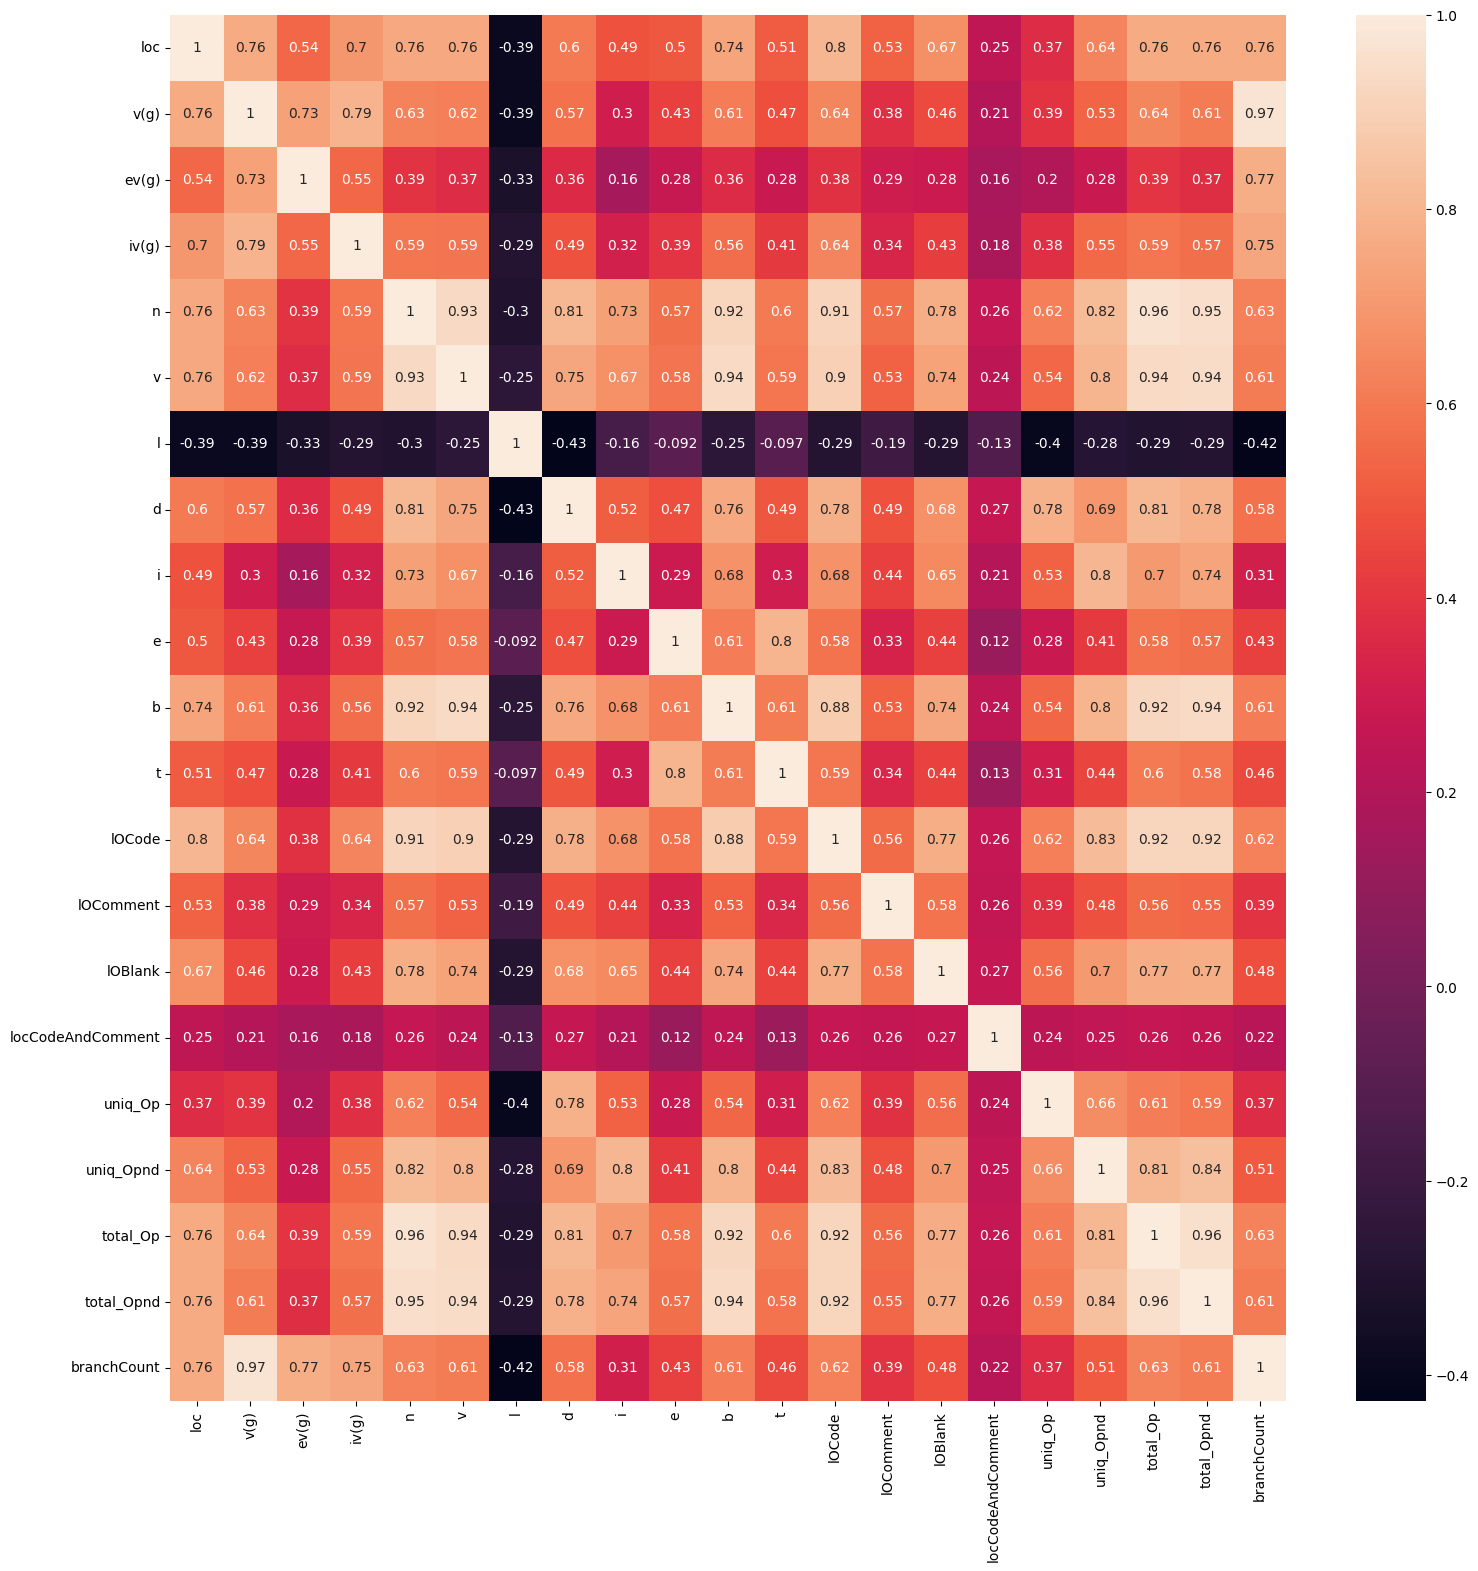

In [10]:
cor = X_train.corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(18,18)) 
ax = sns.heatmap(cor, annot=True)
plt.show()

In [11]:
cor

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
loc,1.000000,0.761509,0.544569,0.696327,0.759605,0.758069,-0.388018,0.599474,0.486427,0.501281,...,0.512228,0.803460,0.528029,0.670751,0.246244,0.367068,0.637582,0.764612,0.761662,0.762755
v(g),0.761509,1.000000,0.729249,0.790553,0.631041,0.618267,-0.387270,0.574305,0.304531,0.430184,...,0.472080,0.641835,0.379520,0.461759,0.208324,0.389917,0.532358,0.639125,0.606453,0.966702
ev(g),0.544569,0.729249,1.000000,0.545255,0.390504,0.367697,-0.325488,0.357735,0.160594,0.275179,...,0.280391,0.382541,0.292689,0.282293,0.164563,0.200460,0.279100,0.394963,0.372867,0.774752
iv(g),0.696327,0.790553,0.545255,1.000000,0.589718,0.585134,-0.291631,0.487112,0.319971,0.394291,...,0.414640,0.636895,0.337728,0.426030,0.178546,0.378869,0.550633,0.591597,0.567097,0.747870
n,0.759605,0.631041,0.390504,0.589718,1.000000,0.928390,-0.300350,0.808291,0.725408,0.569544,...,0.602202,0.911761,0.566374,0.775345,0.262916,0.618021,0.818994,0.963373,0.953080,0.626009
v,0.758069,0.618267,0.367697,0.585134,0.928390,1.000000,-0.254087,0.748121,0.673386,0.582332,...,0.590431,0.899258,0.531985,0.735278,0.242057,0.544283,0.798964,0.936446,0.942189,0.608678
l,-0.388018,-0.387270,-0.325488,-0.291631,-0.300350,-0.254087,1.000000,-0.426309,-0.162300,-0.091764,...,-0.097000,-0.289713,-0.187982,-0.288838,-0.125480,-0.399440,-0.283644,-0.294469,-0.290559,-0.416185
d,0.599474,0.574305,0.357735,0.487112,0.808291,0.748121,-0.426309,1.000000,0.515402,0.471276,...,0.493976,0.778856,0.486619,0.676297,0.268184,0.782781,0.690652,0.808275,0.784738,0.575155
i,0.486427,0.304531,0.160594,0.319971,0.725408,0.673386,-0.162300,0.515402,1.000000,0.286149,...,0.300938,0.677093,0.435828,0.654349,0.214151,0.527640,0.803330,0.702058,0.740201,0.313935
e,0.501281,0.430184,0.275179,0.394291,0.569544,0.582332,-0.091764,0.471276,0.286149,1.000000,...,0.798266,0.580089,0.328993,0.436276,0.124604,0.275824,0.414846,0.579018,0.566986,0.427110


## 4. scale

In [12]:
print(X_train.columns)
print(X_test.columns)

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')
Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')


In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(X_test_scaled, index = X_test.index, columns = X_test.columns)

X_train

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,0.006103,0.004963,0.000000,0.002494,0.007108,0.003447,0.06,0.046772,0.025010,0.000323,...,0.000323,0.006020,0.002907,0.004566,0.0,0.039024,0.008772,0.007011,0.007282,0.007968
1,0.003778,0.002481,0.000000,0.002494,0.003791,0.001871,0.14,0.016738,0.037049,0.000056,...,0.000056,0.003895,0.000000,0.004566,0.0,0.026829,0.010721,0.003321,0.004634,0.003984
2,0.002906,0.002481,0.000000,0.002494,0.005331,0.002445,0.11,0.019249,0.039945,0.000104,...,0.000104,0.002833,0.000000,0.004566,0.0,0.029268,0.010721,0.005166,0.005627,0.003984
3,0.002034,0.000000,0.000000,0.000000,0.002725,0.001163,0.19,0.012554,0.031345,0.000028,...,0.000028,0.001416,0.000000,0.009132,0.0,0.019512,0.005848,0.002952,0.002317,0.000000
4,0.002906,0.002481,0.000000,0.002494,0.002014,0.000754,0.18,0.013462,0.021833,0.000022,...,0.000022,0.002479,0.000000,0.009132,0.0,0.017073,0.005848,0.001845,0.003310,0.003984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,0.002616,0.002481,0.000000,0.000000,0.003317,0.001521,0.15,0.015782,0.032697,0.000048,...,0.000048,0.002479,0.000000,0.004566,0.0,0.026829,0.007797,0.002952,0.003972,0.003984
101759,0.007556,0.009926,0.018293,0.000000,0.012676,0.006926,0.06,0.043042,0.059971,0.000669,...,0.000669,0.008144,0.000000,0.009132,0.0,0.043902,0.019493,0.012362,0.013241,0.015936
101760,0.007265,0.000000,0.000000,0.000000,0.009833,0.004455,0.04,0.054400,0.022044,0.000350,...,0.000350,0.007082,0.000000,0.018265,0.0,0.024390,0.007797,0.009410,0.009268,0.000000
101761,0.002616,0.002481,0.000000,0.002494,0.005094,0.002372,0.15,0.015447,0.051827,0.000091,...,0.000091,0.002479,0.000000,0.004566,0.0,0.026829,0.013645,0.004428,0.006289,0.003984


## 5. GLM - benchmark model

In [14]:
glm_1 = sm.GLM(y_train, X_train, family = sm.families.Binomial())
glm1_fit = glm_1.fit()
print(glm1_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               101763
Model:                            GLM   Df Residuals:                   101742
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47847.
Date:                Mon, 23 Oct 2023   Deviance:                       95695.
Time:                        12:38:44   Pearson chi2:                 1.07e+16
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1219
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
loc                   8.4698      1.24

In [15]:
# p-value 낮은 거 제외 
excluded_variables = ['v(g)', 'ev(g)', 'v', 'd', 'e', 'b', 'total_Op', 'branchCount']
X_train_v2 = X_train.drop(excluded_variables, axis=1)
print(X_train_v2.columns)

Index(['loc', 'iv(g)', 'n', 'l', 'i', 't', 'lOCode', 'lOComment', 'lOBlank',
       'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Opnd'],
      dtype='object')


In [16]:
glm_2 = sm.GLM(y_train, X_train_v2, family = sm.families.Binomial())
glm2_fit = glm_2.fit()
print(glm2_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               101763
Model:                            GLM   Df Residuals:                   101750
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47856.
Date:                Mon, 23 Oct 2023   Deviance:                       95712.
Time:                        12:38:44   Pearson chi2:                 1.52e+16
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1218
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
loc                  10.0480      1.06

### 5.1.Recursive Feature Elimination

In [17]:
if __name__ == "__main__":
    
    lr = LogisticRegression()

    rfe = RFE(lr, step = 10) 
    fit = rfe.fit(X_train, y_train)
    print("Features: {features}".format(features=X_train.columns))
    print("Num Features: {number_features}".format(number_features=fit.n_features_))
    print("Selected Features: {support}".format(support=fit.support_))
    print("Feature Ranking: {ranking}".format(ranking=fit.ranking_))

    selected_columns = [column for column, selected in zip(X_train.columns, fit.support_) if selected]
    print("Selected columns: {selected}".format(selected = selected_columns))

X_train_v3 = X_train[selected_columns]

Features: Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')
Num Features: 10
Selected Features: [ True  True False  True False False  True False  True  True  True  True
 False False  True False False False False False  True]
Feature Ranking: [1 1 3 1 3 3 1 3 1 1 1 1 3 3 1 3 3 2 3 3 1]
Selected columns: ['loc', 'v(g)', 'iv(g)', 'l', 'i', 'e', 'b', 't', 'lOBlank', 'branchCount']


In [18]:
class_weights_to_test = [
    {0: 0.1, 1: 0.9},
    {0: 0.15, 1: 0.85},  
    {0: 0.2, 1: 0.8}, 
    {0: 0.25, 1: 0.75}, 
    {0: 0.3, 1: 0.7},
    {0: 0.35, 1: 0.65},
    {0: 0.4, 1: 0.6},
    {0: 0.45, 1: 0.55},
    {0: 0.5, 1: 0.5},
    {0: 0.55, 1: 0.45},
    {0: 0.6, 1: 0.4}
]

best_class_weights = []
best_accuracies = []

for data in [X_train, X_train_v2, X_train_v3]:
    best_class_weight = None
    best_accuracy = 0.0
    
    for class_weight in class_weights_to_test:
        model = LogisticRegression(class_weight = class_weight)
        accuracy = cross_val_score(model, data, y_train, cv=10, scoring = make_scorer(accuracy_score)).mean()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_class_weight = class_weight
    
    best_class_weights.append(best_class_weight)
    best_accuracies.append(best_accuracy)

# 결과 출력
for i, (best_class_weight, accuracy) in enumerate(zip(best_class_weights, best_accuracies), start=1):
    print(f"Data (X_train_v{i}) - Best Class Weight: {best_class_weight}, Accuracy: {accuracy:.4f}")


Data (X_train_v1) - Best Class Weight: {0: 0.4, 1: 0.6}, Accuracy: 0.8077
Data (X_train_v2) - Best Class Weight: {0: 0.35, 1: 0.65}, Accuracy: 0.8090
Data (X_train_v3) - Best Class Weight: {0: 0.4, 1: 0.6}, Accuracy: 0.8066


## 6. LGBM

In [20]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "num_leaves": trial.suggest_int("num_leaves", 16, 64),
    }

    model = lgb.LGBMClassifier(**params)
    
    accuracy = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1).mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_lgbm_model = lgb.LGBMClassifier(**best_params)

accuracy = cross_val_score(best_lgbm_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1).mean()


print(f'Best LightGBM Model Accuracy: {accuracy:.4f}')


best_lgbm_model.fit(X_train, y_train)
y_pred = best_lgbm_model.predict(X_test)


output_df = pd.DataFrame({'ID': test['id'], 'defects': y_pred})

output_df.to_csv('predictions.csv', index=False)


[I 2023-10-23 12:43:14,938] A new study created in memory with name: no-name-bbd9ca68-a76f-4f01-aea1-ae46454afc03
[I 2023-10-23 12:43:16,678] Trial 0 finished with value: 0.803248758762359 and parameters: {'learning_rate': 0.010754798791439365, 'n_estimators': 95, 'max_depth': 6, 'num_leaves': 21}. Best is trial 0 with value: 0.803248758762359.
[I 2023-10-23 12:43:19,104] Trial 1 finished with value: 0.8133211660295165 and parameters: {'learning_rate': 0.1128096007799681, 'n_estimators': 199, 'max_depth': 7, 'num_leaves': 31}. Best is trial 1 with value: 0.8133211660295165.
[I 2023-10-23 12:43:20,584] Trial 2 finished with value: 0.8133702993184162 and parameters: {'learning_rate': 0.02315888414077935, 'n_estimators': 73, 'max_depth': 6, 'num_leaves': 33}. Best is trial 2 with value: 0.8133702993184162.
[I 2023-10-23 12:43:22,932] Trial 3 finished with value: 0.814814828440688 and parameters: {'learning_rate': 0.022680240809298497, 'n_estimators': 121, 'max_depth': 7, 'num_leaves': 53}

Best LightGBM Model Accuracy: 0.8153
